# Multiple Linear Regression

## My Model

In [131]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots 
%matplotlib inline

import os 
import warnings
warnings.filterwarnings('ignore')

print('Hello Tejas!')

Hello Tejas!


In [132]:
# data 
from ISLP import load_data
data = load_data('Boston')
print(f'dataset: {data.shape}')

dataset: (506, 13)


In [133]:
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [134]:
# independent and dependent variable

yraw = data['medv'].copy()
xraw = data.drop(columns = 'medv').copy()
print(f'Raw X: {xraw.shape}')
print(f'Raw Y: {yraw.shape}')

Raw X: (506, 12)
Raw Y: (506,)


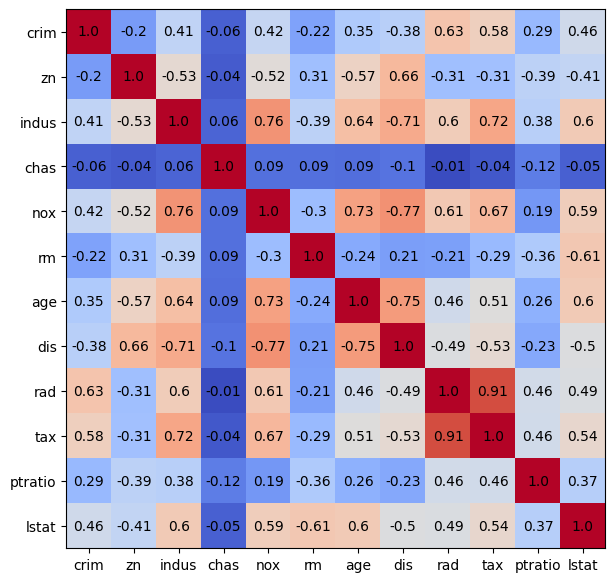

In [135]:
# correlation plot

fig, ax = subplots(figsize = (7,7))

corr_martix = xraw.corr()
ax.imshow(abs(corr_martix), cmap = 'coolwarm')
ax.set_xticks(range(12), labels=corr_martix.columns)
ax.set_yticks(range(12), labels=corr_martix.columns)

for i in range(len(corr_martix)):
    for j in range(len(corr_martix.iloc[i])):
        ax.text(i,j,round(corr_martix.iloc[i,j], 2), ha="center", va="center" )

fig.show()

In [136]:
# regression library
import statsmodels.api as sm


def var_analytics(df, y):
    '''
    input:
        df: indenpendent variables
        y : dependent variable
        
    output:
        DataFrame: with simple linear regression analytics for each column    
    '''
    var_summary = pd.DataFrame(columns = ['corr','adj_r2','pvalue','rsme', 'f_value'])
    for cols in df.columns:
        print(f'working with {cols}..')
        X = df[cols]
        x = sm.add_constant(X)
        model = sm.OLS(y,x)
        result = model.fit()
        var_summary.loc[cols, 'corr'] = np.corrcoef(y,df[cols])[1,0]
        var_summary.loc[cols, 'r2'] = result.rsquared
        var_summary.loc[cols, 'adj_r2'] = result.rsquared_adj
        var_summary.loc[cols, 'pvalue'] = result.pvalues[1]
        var_summary.loc[cols, 'rsme'] = np.sqrt(result.mse_resid)
        var_summary.loc[cols, 'f_value'] = result.fvalue
    return var_summary

simple_reg_summary = var_analytics(xraw,yraw)       

working with crim..
working with zn..
working with indus..
working with chas..
working with nox..
working with rm..
working with age..
working with dis..
working with rad..
working with tax..
working with ptratio..
working with lstat..


In [137]:
# individual var analysis
simple_reg_summary.sort_values(by = ['adj_r2', 'pvalue', 'rsme'], ascending = [False, True, True], inplace = True)
simple_reg_summary

,corr,adj_r2,pvalue,rsme,f_value,r2
lstat,-0.737663,0.543242,0.0,6.21576,601.617871,0.544146
rm,0.69536,0.482501,0.0,6.61616,471.84674,0.483525
ptratio,-0.507787,0.256375,0.0,7.931004,175.105543,0.257847
indus,-0.483725,0.23247,0.0,8.057471,153.954883,0.233990
tax,-0.468536,0.217977,0.0,8.133187,141.761357,0.219526
nox,-0.427321,0.180981,0.0,8.323348,112.59148,0.182603
crim,-0.388305,0.149096,0.0,8.483821,89.486115,0.150780
rad,-0.381626,0.143943,0.0,8.509467,85.914278,0.145639
age,-0.376955,0.140393,0.0,8.527097,83.477459,0.142095
zn,0.360445,0.128194,0.0,8.587384,75.257642,0.129921


In [138]:
# first variable
pvalue_threshold = 0.05
if simple_reg_summary.iloc[0]['pvalue'] < pvalue_threshold:
    first_var = [simple_reg_summary.iloc[0].name]
    max_adj_r2 = simple_reg_summary.iloc[0]['adj_r2']
    print(f'First selected variable: {first_var}, adjusted_r2: {np.round(max_adj_r2, 4)}')
else:
    print(f'increase the p-value threshold')

First selected variable: ['lstat'], adjusted_r2: 0.5432


In [139]:
# Multiple Linear Regression Function

def correlation_check(data, old_cols, new_col, threshold):
    res = True
    if len(old_cols) == 0:
        return True
    else:
        for col in old_cols:
            if abs(np.corrcoef(data[col], data[new_col])[0,1]) > threshold:
                return False
    return res

def model_performance(y, x, old, new):
    features = old + [new]
    final_x = sm.add_constant(x[features])
    final_y = y.copy()
    model = sm.OLS(final_y, final_x)
    result = model.fit()
    return result.rsquared_adj
        
def forward_selection(y, x, final_vars, threshold, adj_r2_threshold):
    selected_vars = final_vars.copy()
    high_correaltion = []
    while(True):
        prev_adj_r2 = adj_r2_threshold
        all_vars = [x for x in x.columns if x not in list(set(selected_vars + high_correaltion))]
        new_r2 = {}
        for col in all_vars:
            if correlation_check(x, selected_vars, col, threshold):
                adj_r2 = model_performance(y, x, selected_vars, col)
                new_r2[col] = adj_r2
                adj_r2_threshold = max(adj_r2_threshold, adj_r2)
                print(f'vars:{selected_vars + [col]}, adj_r2: {np.round(adj_r2, 4)}, prev_adj_r2:{np.round(prev_adj_r2,4)},  max_adj_r2: {np.round(adj_r2_threshold, 4)}')
            else:
                high_correaltion.append(col)
                print(f'{col} not included due to multi-collinearity, absolute correlation: {np.round(max(abs(x[selected_vars + [col]].corr().loc[col].drop(col))), 4)}')
        if prev_adj_r2 == adj_r2_threshold:
            return selected_vars
        for key, value in new_r2.items():
            if value == adj_r2_threshold:
                print(f'Added {key} in the final variables, new adjusted_r2: {np.round(adj_r2_threshold,4)}')
                selected_vars.append(key)

In [140]:
final_vars = forward_selection(y = yraw, x = xraw, final_vars = first_var, threshold = 0.7, adj_r2_threshold = max_adj_r2)

vars:['lstat', 'crim'], adj_r2: 0.5458, prev_adj_r2:0.5432,  max_adj_r2: 0.5458
vars:['lstat', 'zn'], adj_r2: 0.5461, prev_adj_r2:0.5432,  max_adj_r2: 0.5461
vars:['lstat', 'indus'], adj_r2: 0.5447, prev_adj_r2:0.5432,  max_adj_r2: 0.5461
vars:['lstat', 'chas'], adj_r2: 0.5608, prev_adj_r2:0.5432,  max_adj_r2: 0.5608
vars:['lstat', 'nox'], adj_r2: 0.5424, prev_adj_r2:0.5432,  max_adj_r2: 0.5608
vars:['lstat', 'rm'], adj_r2: 0.6371, prev_adj_r2:0.5432,  max_adj_r2: 0.6371
vars:['lstat', 'age'], adj_r2: 0.5495, prev_adj_r2:0.5432,  max_adj_r2: 0.6371
vars:['lstat', 'dis'], adj_r2: 0.5605, prev_adj_r2:0.5432,  max_adj_r2: 0.6371
vars:['lstat', 'rad'], adj_r2: 0.5429, prev_adj_r2:0.5432,  max_adj_r2: 0.6371
vars:['lstat', 'tax'], adj_r2: 0.5488, prev_adj_r2:0.5432,  max_adj_r2: 0.6371
vars:['lstat', 'ptratio'], adj_r2: 0.6051, prev_adj_r2:0.5432,  max_adj_r2: 0.6371
Added rm in the final variables, new adjusted_r2: 0.6371
vars:['lstat', 'rm', 'crim'], adj_r2: 0.6437, prev_adj_r2:0.6371,  m

In [141]:
final_vars

['lstat', 'rm', 'ptratio', 'dis', 'chas', 'tax', 'zn', 'crim']

In [144]:
xraw[final_vars].corr()

,lstat,rm,ptratio,dis,chas,tax,zn,crim
lstat,1.000000,-0.613808,0.374044,-0.496996,-0.053929,0.543993,-0.412995,0.455621
rm,-0.613808,1.000000,-0.355501,0.205246,0.091251,-0.292048,0.311991,-0.219247
ptratio,0.374044,-0.355501,1.000000,-0.232471,-0.121515,0.460853,-0.391679,0.289946
dis,-0.496996,0.205246,-0.232471,1.000000,-0.099176,-0.534432,0.664408,-0.379670
chas,-0.053929,0.091251,-0.121515,-0.099176,1.000000,-0.035587,-0.042697,-0.055892
tax,0.543993,-0.292048,0.460853,-0.534432,-0.035587,1.000000,-0.314563,0.582764
zn,-0.412995,0.311991,-0.391679,0.664408,-0.042697,-0.314563,1.000000,-0.200469
crim,0.455621,-0.219247,0.289946,-0.379670,-0.055892,0.582764,-0.200469,1.000000


In [129]:
# final model
x = sm.add_constant(xraw[final_vars])
model = sm.OLS(yraw, x)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     152.8
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          1.06e-128
Time:                        22:25:57   Log-Likelihood:                -1526.2
No. Observations:                 506   AIC:                             3070.
Df Residuals:                     497   BIC:                             3108.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.8561      3.999      5.466      0.0

# ISLP

In [48]:
import pandas as pd
import numpy as np
from matplotlib.pyplot import subplots
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [49]:
# ISLP

from ISLP import load_data

In [50]:
# statsmodel

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

In [51]:
data = load_data('Boston')
x = data.drop(columns = ['medv']).copy()
y = data['medv'].copy()

print(f'X: {x.shape}')

X: (506, 12)


In [82]:
# Model 
def model_build(y, x, features):
    X = sm.add_constant(x[features])
    model = sm.OLS(y,X)
    result = model.fit()
    print(result.summary())

In [83]:
features = x.columns
model_build(y,x,features)

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.734
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     113.5
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          2.23e-133
Time:                        22:10:12   Log-Likelihood:                -1504.9
No. Observations:                 506   AIC:                             3036.
Df Residuals:                     493   BIC:                             3091.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.6173      4.936      8.431      0.0

In [84]:
# variance_inflation_factor
VIF?

Signature: VIF(exog, exog_idx)
Docstring:
Variance inflation factor, VIF, for one exogenous variable

The variance inflation factor is a measure for the increase of the
variance of the parameter estimates if an additional variable, given by
exog_idx is added to the linear regression. It is a measure for
multicollinearity of the design matrix, exog.

One recommendation is that if VIF is greater than 5, then the explanatory
variable given by exog_idx is highly collinear with the other explanatory
variables, and the parameter estimates will have large standard errors
because of this.

Parameters
----------
exog : {ndarray, DataFrame}
    design matrix with all explanatory variables, as for example used in
    regression
exog_idx : int
    index of the exogenous variable in the columns of exog

Returns
-------
float
    variance inflation factor

Notes
-----
This function does not save the auxiliary regression.

See Also
--------
xxx : class for regression diagnostics  TODO: does not exist

In [85]:
# VIF
X = sm.add_constant(x)
{X.columns[i]: np.round(VIF(X,i), 4) for i in range(1, len(X.columns))}

{'crim': 1.7675,
 'zn': 2.2985,
 'indus': 3.9872,
 'chas': 1.0712,
 'nox': 4.3691,
 'rm': 1.9125,
 'age': 3.0882,
 'dis': 3.954,
 'rad': 7.4453,
 'tax': 9.0022,
 'ptratio': 1.7971,
 'lstat': 2.8708}

In [90]:
features = features.drop('tax')
features

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad',
       'ptratio', 'lstat'],
      dtype='object')

In [91]:
model_build(y, x, features)

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     120.4
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          4.68e-132
Time:                        22:11:37   Log-Likelihood:                -1510.6
No. Observations:                 506   AIC:                             3045.
Df Residuals:                     494   BIC:                             3096.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8673      4.958      8.041      0.0

In [92]:
features = features.drop('age') # age had hgh p_value

In [93]:
features

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio',
       'lstat'],
      dtype='object')

In [94]:
model_build(y,x,features)

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.723
Method:                 Least Squares   F-statistic:                     132.7
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          4.02e-133
Time:                        22:12:53   Log-Likelihood:                -1510.6
No. Observations:                 506   AIC:                             3043.
Df Residuals:                     495   BIC:                             3090.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8099      4.942      8.055      0.0

In [95]:
features = features.drop('indus')
features

Index(['crim', 'zn', 'chas', 'nox', 'rm', 'dis', 'rad', 'ptratio', 'lstat'], dtype='object')

In [96]:
model_build(y,x,features)

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     146.9
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          8.23e-134
Time:                        22:13:37   Log-Likelihood:                -1511.5
No. Observations:                 506   AIC:                             3043.
Df Residuals:                     496   BIC:                             3085.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9841      4.945      8.085      0.0